In [1]:
!pip install tf-nightly
!pip install focal-loss

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.8/490.8 MB 1.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 72.7 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 34.3 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.1.0
    Uninstalling ml-dtypes-0.1.0:
      Successfully uninstalled ml-dtypes-0.1.0


In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import os
import math
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras import Model

xpath='/kaggle/input/sentinel1-sar-images-turkey/Turkey/img_dir'
ypath='/kaggle/input/sentinel1-sar-images-turkey/Turkey/ann_dir'
trn_hist_path='/home/20bce131/model/train_hist/'
trn_out_path='/home/20bce131/model/trn_imgs_out'
val_out_path='/home/20bce131/model/val_imgs_out'

batch_size = 32
num_epochs = 25
learning_rate=1e-2
gamma = 0.9
decay_steps = 10

In [3]:
def visualize_sample(img, label, title, path=''):
    label = tf.transpose(label, perm=[2,0,1])
    fig, ax = plt.subplots(1, 6, figsize=(20,20))
    for i, subplot_ax in zip(range(5 + 1), ax.flatten()):
        if i == 0: 
            subplot_ax.imshow(img)
            subplot_ax.set_title(title)
        else:
            subplot_ax.imshow(label[i-1], cmap='gray', vmin=0, vmax=1)
            subplot_ax.set_title(f'Label {i}')
    if path != '':
        plt.savefig(f'{path}/{title}.png')
    
def get_iou(preds, label):
    classwise_iou = []
    num_classes = 5
    preds = tf.argmax(preds, axis=-1)
    label = tf.argmax(label, axis=-1)
    for c in range(num_classes):
        tp = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(label, c), tf.equal(preds, c)), dtype=tf.float32))
        fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.not_equal(label, c), tf.equal(preds, c)), dtype=tf.float32))
        fn = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(label, c), tf.not_equal(preds, c)), dtype=tf.float32))
        iou = tp / (tp + fn + fp)
        if tf.math.is_nan(iou): continue
        classwise_iou.append(iou)
    classwise_iou = tf.stack(classwise_iou)
    miou = tf.reduce_mean(classwise_iou)
    return miou

def get_sample_from_val(idx):
    idx_num = idx % batch_size
    batch_num = int((idx-idx_num) / batch_size)
    imgs, labels = val.__getitem__(batch_num)
    img, label = imgs[idx_num], labels[idx_num]
    return img, label

In [4]:
class Train(tf.keras.utils.Sequence):
    def __init__(self, imgs, batch_size=batch_size):
        self.num_classes = 5
        self.height, self.width = 256, 256
        self.xtrain_path = xpath
        self.ytrain_path = ypath
        self.imgs = imgs
        self.batch_size = batch_size
        
        self.xtrain = []
        self.ytrain = []
        for img_name in self.imgs:
            xtrain = tf.keras.preprocessing.image.load_img(
                os.path.join(self.xtrain_path, img_name), target_size=(self.height, self.width)
            )
            xtrain = tf.keras.preprocessing.image.img_to_array(xtrain)
            self.xtrain.append(xtrain)

            ytrain = tf.keras.preprocessing.image.load_img(
                os.path.join(self.ytrain_path, img_name), target_size=(self.height, self.width),
                color_mode='grayscale'
            )
            ytrain = tf.keras.preprocessing.image.img_to_array(ytrain)
            ytrain = tf.squeeze(ytrain)
            ytrain = self.process_label(ytrain)
            ytrain = tf.transpose(ytrain, perm=[1,2,0])
            self.ytrain.append(ytrain)

        self.xtrain = tf.stack(self.xtrain)
        self.ytrain = tf.stack(self.ytrain)
        self.xtrain = self.xtrain / 255.0

    def __getitem__(self, idx):
        return self.xtrain[idx * self.batch_size : (idx + 1) * self.batch_size], self.ytrain[idx * self.batch_size : (idx + 1) * self.batch_size]

    def __len__(self):
        return math.ceil(len(self.imgs) / self.batch_size)
    
    def process_label(self, label):
        r = []
        for i in range(self.num_classes):
            mask = tf.cast(tf.equal(label, i+1), dtype=tf.float32)
            r.append(mask)
        return tf.stack(r)
    
class Validate(tf.keras.utils.Sequence):
    def __init__(self, imgs, batch_size=batch_size):
        self.num_classes = 5
        self.height, self.width = 256, 256
        self.xtrain_path = xpath
        self.ytrain_path = ypath
        self.imgs = imgs
        self.batch_size = batch_size
        
        self.xtrain = []
        self.ytrain = []
        for img_name in self.imgs:
            xtrain = tf.keras.preprocessing.image.load_img(
                os.path.join(self.xtrain_path, img_name), target_size=(self.height, self.width)
            )
            xtrain = tf.keras.preprocessing.image.img_to_array(xtrain)
            self.xtrain.append(xtrain)

            ytrain = tf.keras.preprocessing.image.load_img(
                os.path.join(self.ytrain_path, img_name), target_size=(self.height, self.width),
                color_mode='grayscale'
            )
            ytrain = tf.keras.preprocessing.image.img_to_array(ytrain)
            ytrain = tf.squeeze(ytrain)
            ytrain = self.process_label(ytrain)
            ytrain = tf.transpose(ytrain, perm=[1,2,0])
            self.ytrain.append(ytrain)

        self.xtrain = tf.stack(self.xtrain)
        self.ytrain = tf.stack(self.ytrain)
        self.xtrain = self.xtrain / 255.0

    def __getitem__(self, idx):
        return self.xtrain[idx * self.batch_size : (idx + 1) * self.batch_size], self.ytrain[idx * self.batch_size : (idx + 1) * self.batch_size]

    def __len__(self):
        return math.ceil(len(self.imgs) / self.batch_size)
    
    def process_label(self, label):
        r = []
        for i in range(self.num_classes):
            mask = tf.cast(tf.equal(label, i+1), dtype=tf.float32)
            r.append(mask)
        return tf.stack(r)

In [5]:
imgs = np.array(os.listdir(xpath))[:1000]
train_imgs, val_imgs = train_test_split(imgs, test_size=0.2)
train = Train(train_imgs)
val = Validate(val_imgs)

In [11]:
VGG_Weights_path = "/kaggle/input/vgg16weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"


n_classes = 5
def FCN8( nClasses ,  input_height=224, input_width=224):
    ## input_height and width must be devisible by 32 because maxpooling with filter size = (2,2) is operated 5 times,
    ## which makes the input_height and width 2^5 = 32 times smaller
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last"

    img_input = Input(shape=(input_height,input_width, 3)) ## Assume 224,224,3
   
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
   
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)

    #x = Flatten(name='flatten')(x)
    #x = Dense(4096, activation='relu', name='fc1')(x)
    # <--> o = ( Conv2D( 4096 , ( 7 , 7 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
   
    #x = Dense(4096, activation='relu', name='fc2')(x)
    # <--> o = ( Conv2D( 4096 , ( 1 , 1 ) , activation='relu' , padding='same', data_format=IMAGE_ORDERING))(o)  
    # assuming that the input_height = input_width = 224 as in VGG data
   
    #x = Dense(1000 , activation='softmax', name='predictions')(x)
    # <--> o = ( Conv2D( nClasses ,  ( 1 , 1 ) ,kernel_initializer='he_normal' , data_format=IMAGE_ORDERING))(o)
    # assuming that the input_height = input_width = 224 as in VGG data
   
   
    vgg  = Model(  img_input , pool5  )
    vgg.load_weights(VGG_Weights_path) ## loading VGG weights for the encoder parts of FCN8
   
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
   
   
    ## 4 times upsamping for pool4 layer
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2 times upsampling for pool411
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
   
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
       
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
   
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224,
             input_width  = 224)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                                                                                            

In [12]:
from keras import optimizers


sgd = optimizers.SGD(lr=1E-2, momentum=0.9, nesterov=True)
model.compile(loss='categorical_focal_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(train,
                  validation_data=val,
                  batch_size=32,epochs=20,verbose=2)

Epoch 1/20
25/25 - 39s - loss: 0.2695 - accuracy: 0.1998 - val_loss: 0.2574 - val_accuracy: 0.2034 - 39s/epoch - 2s/step
Epoch 2/20
25/25 - 16s - loss: 0.2573 - accuracy: 0.2030 - val_loss: 0.2573 - val_accuracy: 0.2010 - 16s/epoch - 631ms/step
Epoch 3/20
25/25 - 16s - loss: 0.2572 - accuracy: 0.2018 - val_loss: 0.2572 - val_accuracy: 0.2032 - 16s/epoch - 641ms/step
Epoch 4/20
25/25 - 16s - loss: 0.2570 - accuracy: 0.2042 - val_loss: 0.2571 - val_accuracy: 0.2033 - 16s/epoch - 639ms/step
Epoch 5/20
25/25 - 17s - loss: 0.2569 - accuracy: 0.2054 - val_loss: 0.2569 - val_accuracy: 0.2053 - 17s/epoch - 662ms/step
Epoch 6/20
25/25 - 16s - loss: 0.2567 - accuracy: 0.2078 - val_loss: 0.2567 - val_accuracy: 0.2091 - 16s/epoch - 649ms/step
Epoch 7/20
25/25 - 17s - loss: 0.2565 - accuracy: 0.2100 - val_loss: 0.2565 - val_accuracy: 0.2120 - 17s/epoch - 664ms/step
Epoch 8/20
25/25 - 16s - loss: 0.2563 - accuracy: 0.2128 - val_loss: 0.2563 - val_accuracy: 0.2119 - 16s/epoch - 635ms/step
Epoch 9/20


In [ ]:
# model = Network()
# model.build(input_shape=(batch_size,256,256,3))

In [ ]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate = learning_rate,
#     decay_steps=decay_steps,
#     decay_rate=gamma,
#     staircase=True
# )
# optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
# model.compile(optimizer=optim, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
# hist = model.fit(train, steps_per_epoch=train.__len__(), epochs=num_epochs, validation_data=val)

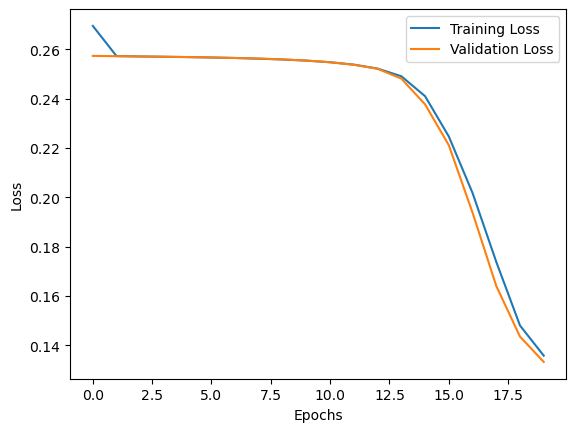

<Figure size 640x480 with 0 Axes>

In [13]:
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(hist1.history['loss'], label='Training Loss')
plt.plot(hist1.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
plt.clf()

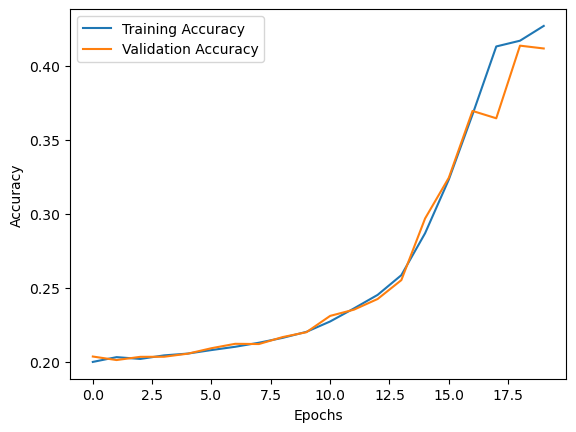

In [14]:
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(hist1.history['accuracy'], label='Training Accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [15]:
preds = model.predict(val)
iou = get_iou(preds, val.ytrain)
print(f'Mean IoU : {iou}')

7/7 [==============================] - 2s 231ms/step
Mean IoU : 0.17663560807704926


[131 200  33 177 149]


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2423, in predict_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2408, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2396, in run_step  **
        outputs = model.predict_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 2364, in predict_step
        return self(x, training=False)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 256, 256, 3)


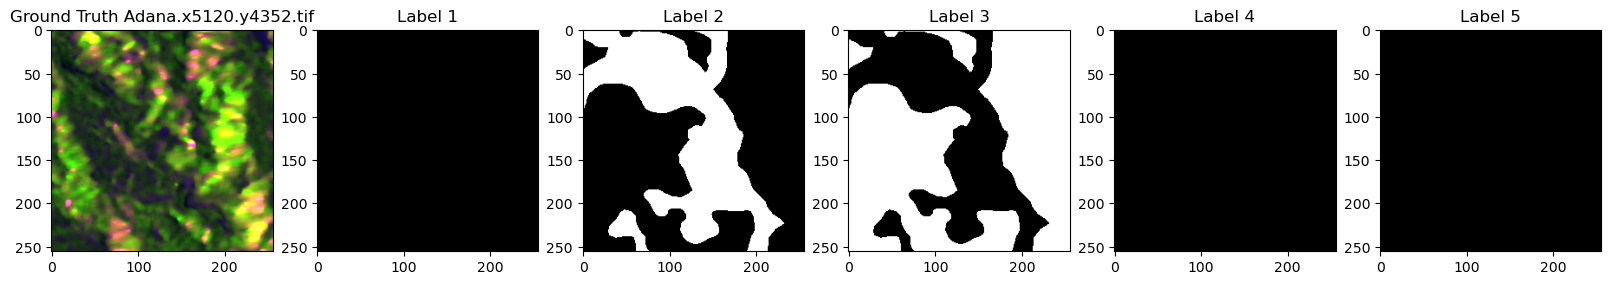

In [16]:
idxs = np.random.randint(0, len(val)*batch_size+1, (5,))
print(idxs)
for i in idxs:
    img, label = get_sample_from_val(i)
    visualize_sample(img, label, f'Ground Truth {val_imgs[i]}')
    pred = model.predict(tf.expand_dims(img, axis=0))
    visualize_sample(img, tf.squeeze(pred), f'Model Predictions {val_imgs[i]}')